In [1]:
from twitter import *
import json
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading my authentication tokens
with open('auth_dict.json','r') as f:
    twtr_auth = json.load(f)

# To make it more readable, lets store
# the OAuth credentials in strings first.
CONSUMER_KEY = twtr_auth['consumer_key']
CONSUMER_SECRET = twtr_auth['consumer_secret']
OAUTH_TOKEN = twtr_auth['token']
OAUTH_TOKEN_SECRET = twtr_auth['token_secret']
    
# Then, we store the OAuth object in "auth"
auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)
# Notice that there are four tokens - you need to create these in the
# Twitter Apps dashboard after you have created your own "app".

# We now create the twitter search object.
t = Twitter(auth=auth)

In [3]:
import sys
import time
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        if e.e.code == 401:
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*10 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [4]:
# Create a mostly empty data frame,
# and write it to a CSV file.
df = pd.DataFrame(columns=['ID','followers'])
df.to_csv('followers.csv', index=False)

# Our function
def save_followers(fid, followers):
    df = pd.DataFrame([[fid, followers]], columns=['ID','followers'])
    with open('followers.csv', 'a') as f:
        df.to_csv(f,header=False, index=False)

In [5]:
def get_user_profile(t, user_ids):
    
    items_to_info = {}
    items = user_ids
    while len(items) > 0:
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]
        response = make_twitter_request(t.users.lookup, user_id= items_str)
   
        for user_info in response:
            items_to_info[user_info['id']] = user_info
                
    return items_to_info

In [6]:
def get_followers_count(user_prof):
    followers_count = {}
    for key in user_prof:
        user_info = user_prof[key]
        followers_count[key] = user_info['followers_count']
    return followers_count

In [7]:
def get_top_friends(seed_id):
     # Getting friends' ids
    response = make_twitter_request(t.friends.ids,user_id=seed_id, count = 1000)
    friends = response["ids"]

    # Getting followers' ids
    response = make_twitter_request(t.followers.ids,user_id=seed_id, count = 1000)
    followers = response["ids"]

    # Computing reciprocal friends
    
    reciprocal_friends = set(friends) & set(followers)
    top_five = heapq.nlargest(5, reciprocal_friends)
    items_to_info = get_user_profile(t, user_ids= top_five)
    
    count = {}
    count = get_followers_count(items_to_info)
    max_count = heapq.nlargest(5, count.values())

    top_friend = []
    for max_c in max_count:
        for key, value in  count.items():
            if (value == max_c):
                top_friend.append(key)

    top_friend = top_friend[:5]
    print('Total Number of reciprocal ids fetched id : {0} {1} ids for {2}'.format(len(top_friend), 'Reciprocal Friends', seed_id, file=sys.stderr))
    print(top_friend)
    save_followers(str(seed_id), ','.join([str(x) for x in top_friend]))
    return top_friend, len(top_friend)

In [8]:
import heapq, random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
# Though the following import is not directly being used, it is required
# for 3D projection to work
# Selecting a user
screen_name = 'zedshaw'

#Resolve the ID for screen_name and start working with IDs for consistency
seed_id = t.users.show(screen_name=screen_name)['id']
next_queue = [seed_id]
number = 1
depth = 3
d = 1
friends = {}
while d < depth:
    d += 1
    (queue, next_queue) = (next_queue, [])
    for fid in queue:
        top_friends, n = get_top_friends(fid)
        save_followers(fid,  top_friends)
        friends[fid] = top_friends
        number += n
        print(number)
        next_queue += top_friends
        
        
def edgeGeneration(graph):
    edges = []
    for n1 in graph:
        for n2 in graph[n1]:
            edges.append((n1, n2))
    return edges
            

Total Number of reciprocal ids fetched id : 5 Reciprocal Friends ids for 15029296
[1020961, 1434051, 581092177, 3562421, 17198807]
6
Total Number of reciprocal ids fetched id : 1 Reciprocal Friends ids for 1020961
[1186]
7
Total Number of reciprocal ids fetched id : 5 Reciprocal Friends ids for 1434051
[848351570114732033, 859976757146824704, 872985734956830721, 890971653211119616, 948240637823987713]
12
Total Number of reciprocal ids fetched id : 5 Reciprocal Friends ids for 581092177
[946819464045236231, 951454517941465088, 958864532792897536, 964660128418095104, 924626795202088960]
17
Total Number of reciprocal ids fetched id : 5 Reciprocal Friends ids for 3562421
[954114873050492928, 949336566006153217, 964170150835564544, 954204043873669120, 952930004035399680]
22
Total Number of reciprocal ids fetched id : 5 Reciprocal Friends ids for 17198807
[1361917154, 2805627770, 1641345408, 2343741413, 2890705000]
27


In [9]:
with open('json_dict','w') as f:
    json.dump(friends,f)

In [10]:
A = {}
with open('friend.json','r') as f:
    A = json.load(f)

In [11]:
B = {}
for key, value in A.items():
    B[int(key)] = value

In [12]:
edges = edgeGeneration(B)

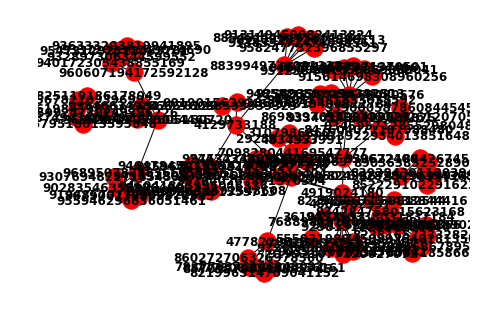

In [13]:
H=nx.Graph(edges)
nx.draw(H, with_labels=True,font_weight='bold', node_color = 'r',plot_width=2000,plot_height=2000)
plt.show()


In [14]:
#Community detection using K-Clique method
#k_comm_2 = list(nx.community.k_clique_communities(H,2))

#community_dic={}
#i=1
#for value in k_comm_2:
#    community_dic[i]=value
#   i+=1
#dict_size = len(community_dic)
#dict_size
#ebtwn = nx.edge_betweenness(H).values()
#ebtwn = list(ebtwn)
#ebtwn.index(max(ebtwn))
#d = list(nx.algorithms.components.connected_components(H))
#len(d)
#pos = nx.spring_layout(H)
#nx.draw_networkx_nodes(H,pos,nodelist=community_dic[1],node_color='r',node_size=10,alpha=1,plot_width=2000,plot_height=2000)

#nx.draw_networkx_edges(H,pos)
#plt.show()

In [15]:
#**************Spectral Clustering***************#
#RG = nx.from_numpy_array(B.toarray())
A = nx.adjacency_matrix(H)
D = np.diag(list(dict(nx.degree(H)).values()))
L = D - A
lmbds,vctrs = np.linalg.eig(L)
sorted(lmbds)

len(list(nx.components.connected_components(H)))
indx = [i for i in range(len(lmbds)) if lmbds[i] > .01 and lmbds[i] < .1]
indx

[18, 19, 20, 21]

In [16]:
RG_mbd = vctrs[:,indx]
RG_mbd

est = KMeans(n_clusters=4)
print(est)

est.fit(RG_mbd)
labels = est.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


/Users/anaghafatale/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [17]:
len(labels)

#labels

#help(KMeans)

101

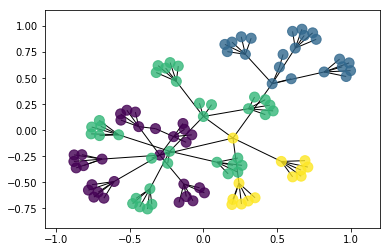

In [18]:
pos = nx.spring_layout(H)
nx.draw_networkx_nodes(H,pos,node_color=labels,node_size=100,alpha=0.8)
nx.draw_networkx_edges(H,pos)
plt.show()